# Import necessary libraries for data manipulation, model building, and evaluation


In [1]:
import pandas as pd
import numpy as np
#import
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'seaborn'

# Load the dataset from a CSV file into a pandas DataFrame

In [4]:
df = pd.read_csv('/content/housing.csv')
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


In [5]:
df.columns

Index(['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
       'Avg. Area Number of Bedrooms', 'Area Population', 'Price', 'Address'],
      dtype='object')

# to check if any value is empty in the dataset provided

In [6]:
df.isnull().sum()

,0
Avg. Area Income,0
Avg. Area House Age,0
Avg. Area Number of Rooms,0
Avg. Area Number of Bedrooms,0
Area Population,0
Price,0
Address,0


# ---------------------------------------------------------------------------------------------------------------------------------------------

# OUTLIER CHECKING

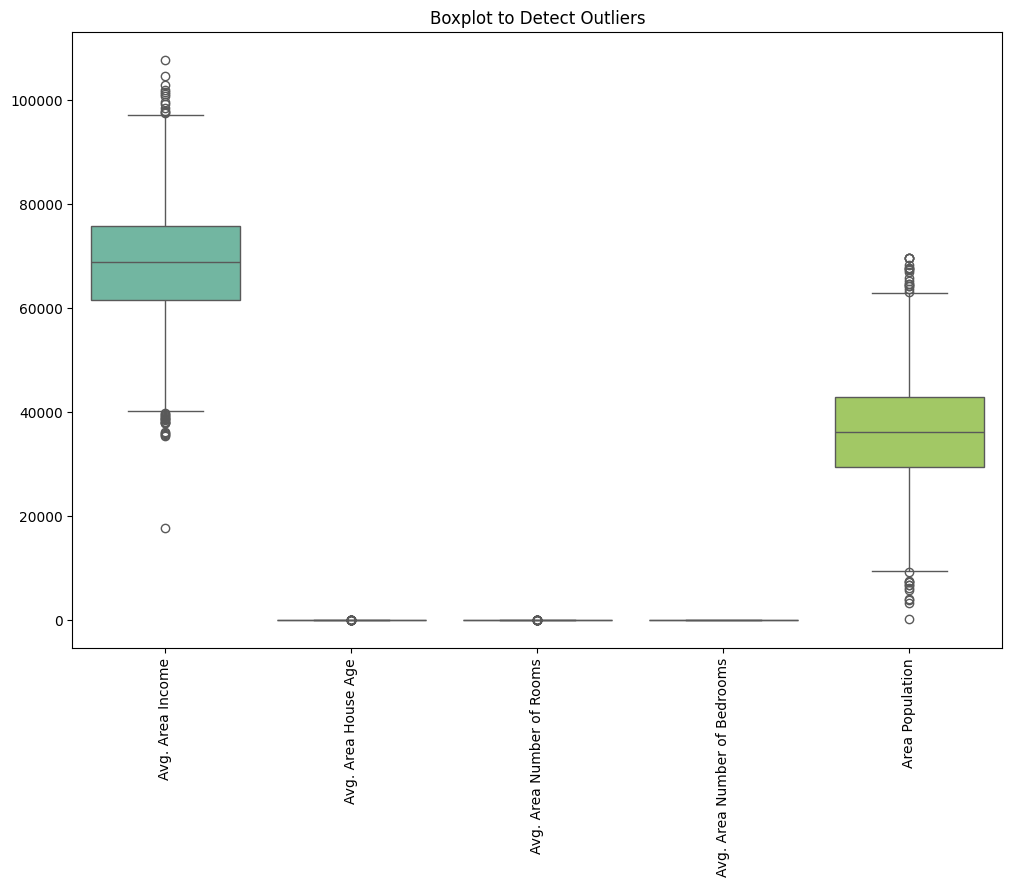

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing outliers with a boxplot for each feature
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.drop(columns=['Price']), palette="Set2")
plt.title('Boxplot to Detect Outliers')
plt.xticks(rotation=90)
plt.show()


In [8]:
# Define a function to filter out outliers based on the IQR method
def filter_outliers(df):
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=['number'])

    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = numeric_cols.quantile(0.25)
    Q3 = numeric_cols.quantile(0.75)

    # Calculate IQR (Interquartile Range)
    IQR = Q3 - Q1

    # Filter the dataset to remove outliers (those outside 1.5 * IQR)
    df_filtered = df[~((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).any(axis=1)]

    return df_filtered

# Apply the function to your dataset
df_filtered = filter_outliers(df)

# Display the shape of the dataset before and after outlier removal
print(f"Original dataset shape: {df.shape}")
print(f"Filtered dataset shape: {df_filtered.shape}")

# Check the first few rows of the filtered dataset
df_filtered.head()


Original dataset shape: (5000, 7)
Filtered dataset shape: (4865, 7)


,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


# 135 OUTLIER WERE DETECTED AND WERE REMOVED FROM THE ORIGINAL DATASET AND THEN A XGBOOST REGRESSOR IS TRAINED.

In [9]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
# Ensure we drop non-numeric columns like 'Address'
X_filtered = df_filtered.drop(['Price', 'Address'], axis=1)  # Dropping 'Price' and 'Address'
y_filtered = df_filtered['Price']

# Split the data into training and testing sets
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'max_depth': [2, 3, 4],                # Fine-tuning around the best value
    'learning_rate': [0.05, 0.1, 0.15],    # Trying slightly higher or lower values
    'n_estimators': [250, 300, 350],       # More rounds around the optimal
    'colsample_bytree': [0.3, 0.4, 0.5],   # Trying slightly higher sample sizes
    'alpha': [15, 20, 25]                  # Tuning around best regularization parameter
}

# Create a list of parameter combinations using ParameterGrid
param_list = list(ParameterGrid(param_grid))

# Initialize XGBoost regressor
xg_reg_filtered = xgb.XGBRegressor(objective='reg:squarederror')

# Track progress with tqdm
best_rmse_filtered = float('inf')
best_params_filtered = None

# Loop through parameter combinations and fit the model on filtered dataset
for params in tqdm(param_list, desc="Hyperparameter Tuning Progress (Filtered Data)"):
    xg_reg_filtered.set_params(**params)
    xg_reg_filtered.fit(X_train_filtered, y_train_filtered)

    # Predict on the filtered test set
    y_pred_filtered = xg_reg_filtered.predict(X_test_filtered)

    # Calculate RMSE
    rmse_filtered = mean_squared_error(y_test_filtered, y_pred_filtered, squared=False)

    # Track the best RMSE and corresponding parameters
    if rmse_filtered < best_rmse_filtered:
        best_rmse_filtered = rmse_filtered
        best_params_filtered = params

# After all fits, display the best parameters and RMSE for the filtered dataset
print(f"Best hyperparameters (filtered): {best_params_filtered}")
print(f"Best RMSE (filtered): {best_rmse_filtered}")

# Train the model with the best found parameters on the filtered dataset
best_xg_reg_filtered = xgb.XGBRegressor(**best_params_filtered)
best_xg_reg_filtered.fit(X_train_filtered, y_train_filtered)

# Predict on the filtered test set
y_pred_final_filtered = best_xg_reg_filtered.predict(X_test_filtered)

# Calculate final RMSE, R-squared, and MAE on the filtered test set
rmse_final_filtered = mean_squared_error(y_test_filtered, y_pred_final_filtered, squared=False)
r2_final_filtered = r2_score(y_test_filtered, y_pred_final_filtered)

print(f"Final RMSE (filtered): {rmse_final_filtered}")
print(f"Final R-squared (filtered): {r2_final_filtered}")


Hyperparameter Tuning Progress (Filtered Data): 100%|██████████| 243/243 [01:02<00:00,  3.89it/s]

Best hyperparameters (filtered): {'alpha': 25, 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 350}
Best RMSE (filtered): 105817.35504253393
Final RMSE (filtered): 105817.35504253393
Final R-squared (filtered): 0.9050500383366542


# Training model after removing outliers following values:
1. RMSE : 105817.355
2. R-Squared : 0.90



# ------------------------------------------------------------------------------------------------------------------------------------------

# Drop the 'Address' column, as it's not useful for prediction

In [10]:
df = df.drop('Address', axis=1)
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05


# correlation matrix to understand relationship between attributes and with target variable

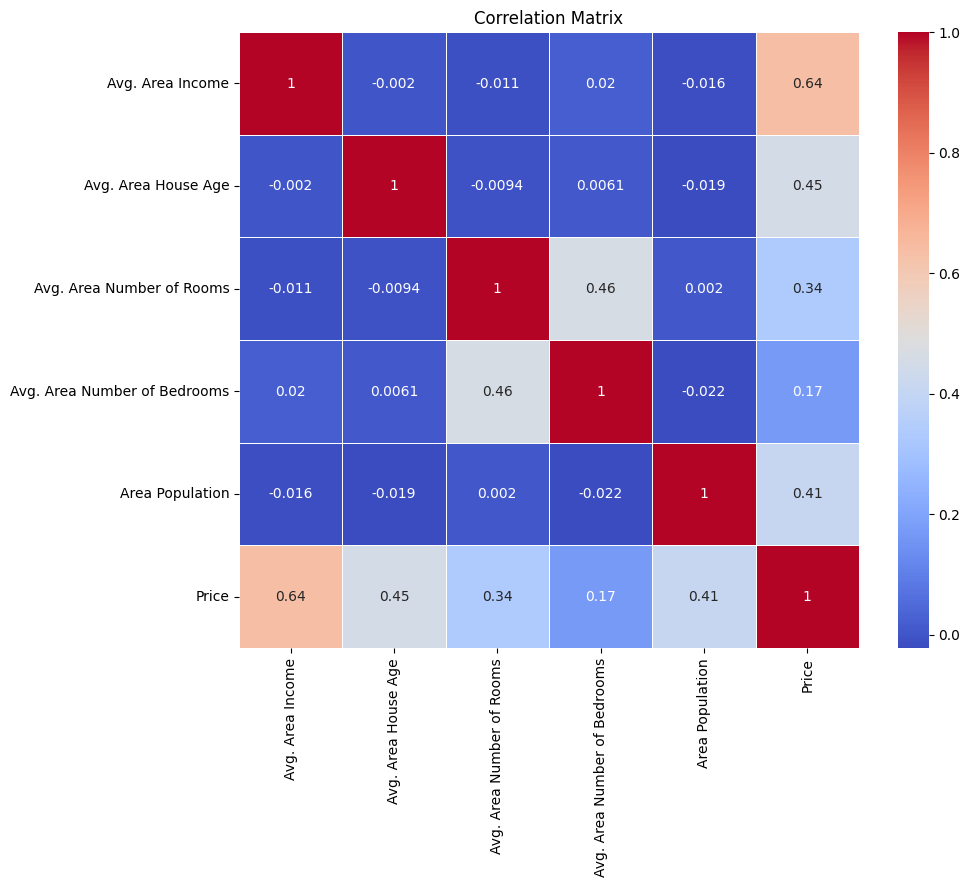

In [11]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


# All the features exhibit some degree of positive correlation with Price, confirming that they are relevant to the prediction of housing prices. Therefore, no features should be dropped, as they all provide useful information for the model.

# now training model without removing the outlier.

# checking minimum and maximum values of each column to understand thier range

In [12]:
# Print the max and min values for each column to understand the range
print("Avg. Area Income: Max =", df['Avg. Area Income'].max(), ", Min =", df['Avg. Area Income'].min())
print("Avg. Area House Age: Max =", df['Avg. Area House Age'].max(), ", Min =", df['Avg. Area House Age'].min())
print("Avg. Area Number of Rooms: Max =", df['Avg. Area Number of Rooms'].max(), ", Min =", df['Avg. Area Number of Rooms'].min())
print("Avg. Area Number of Bedrooms: Max =", df['Avg. Area Number of Bedrooms'].max(), ", Min =", df['Avg. Area Number of Bedrooms'].min())
print("Area Population: Max =", df['Area Population'].max(), ", Min =", df['Area Population'].min())
print("Price: Max =", df['Price'].max(), ", Min =", df['Price'].min())


Avg. Area Income: Max = 107701.7484 , Min = 17796.63119
Avg. Area House Age: Max = 9.519088066 , Min = 2.644304186
Avg. Area Number of Rooms: Max = 10.75958834 , Min = 3.236194023
Avg. Area Number of Bedrooms: Max = 6.5 , Min = 2.0
Area Population: Max = 69621.71338 , Min = 172.6106863
Price: Max = 2469065.594 , Min = 15938.65792


# ---------------------------------------------------------------------------------------------------------------------------------------------

# As mentioned in the Assignment document that XGBoost should be used for building regressor model and XGBoost is not heavily reliant on standardized data due to how it splits trees, so the performance gain may be marginal. We might also lose interpretability for features like income or population.

# ---------------------------------------------------------------------------------------------------------------------------------------------

# Defining the features (X) and the target variable (y). Features are all columns except 'Price', and 'Price' is our target. Spliting the dataset into training (80%) and testing (20%) sets

In [13]:
from sklearn.model_selection import train_test_split


X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits to ensure they are correct
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (4000, 5), X_test shape: (1000, 5)
y_train shape: (4000,), y_test shape: (1000,)


# To train an XGBoost regression model using the default hyperparameters and then calculate the RMSE and R-squared values

In [14]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost regressor with default hyperparameters
xg_reg_default = xgb.XGBRegressor(objective='reg:squarederror')

# Train the model with default parameters
xg_reg_default.fit(X_train, y_train)

# Predict on the test set
y_pred_default = xg_reg_default.predict(X_test)

# Calculate RMSE
rmse_default = mean_squared_error(y_test, y_pred_default, squared=False)
print(f"Default XGBoost RMSE: {rmse_default}")

# Calculate R-squared
r2_default = r2_score(y_test, y_pred_default)
print(f"Default XGBoost R-squared: {r2_default}")


Default XGBoost RMSE: 122117.7790954811
Default XGBoost R-squared: 0.8787900954386907


# To perform hyperparameter tuning for an XGBoost regression model using a custom loop with ParameterGrid and tqdm, tracking the best combination based on RMSE.

In [15]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

# Define a narrower parameter grid based on the best results you got
param_grid = {
    'max_depth': [2, 3, 4],                # Fine-tuning around the best value
    'learning_rate': [0.05, 0.1, 0.15],    # Trying slightly higher or lower values
    'n_estimators': [250, 300, 350],       # More rounds around the optimal
    'colsample_bytree': [0.3, 0.4, 0.5],   # Trying slightly higher sample sizes
    'alpha': [15, 20, 25]                  # Tuning around best regularization parameter
}

# Create a list of parameter combinations using ParameterGrid
param_list = list(ParameterGrid(param_grid))

# Initialize XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# To track progress with tqdm, use a custom loop for fitting
best_rmse = float('inf')
best_params = None

# Loop through parameter combinations and fit the model
for params in tqdm(param_list, desc="Hyperparameter Tuning Progress"):
    xg_reg.set_params(**params)
    xg_reg.fit(X_train, y_train)

    # Predict on the test set
    y_pred = xg_reg.predict(X_test)

    # Calculate RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Track the best RMSE and corresponding parameters
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# After all fits, display the best parameters and RMSE
print(f"Best hyperparameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

# Train the model with the best found parameters
best_xg_reg = xgb.XGBRegressor(**best_params)
best_xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = best_xg_reg.predict(X_test)

# Calculate final RMSE, R-squared, and MAE
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Final RMSE: {rmse}")
print(f"R-squared: {r2}")


Hyperparameter Tuning Progress: 100%|██████████| 243/243 [00:42<00:00,  5.72it/s]

Best hyperparameters: {'alpha': 25, 'colsample_bytree': 0.3, 'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 350}
Best RMSE: 104090.29949411274
Final RMSE: 104090.29949411274
R-squared: 0.9119355086993447


# In this analysis, I explored the impact of removing outliers on model performance. After comparing the results of training the model with and without outliers, I found that the model performs better without removing outliers. Here are the key differences:
With Outliers:

1.   RMSE: 104,090
2.   R-squared: 0.912

With Outliers Removed:

1.   RMSE: 105,817
2.   R-squared: 0.905

# Although outliers are often thought of as noise or errors, in this case, they seem to represent important information about the dataset. Thus, removing the outliers led to a slight reduction in model performance, indicating that these data points are likely valid and provide useful information for prediction. Therefore, keeping the outliers in this dataset results in better model performance.


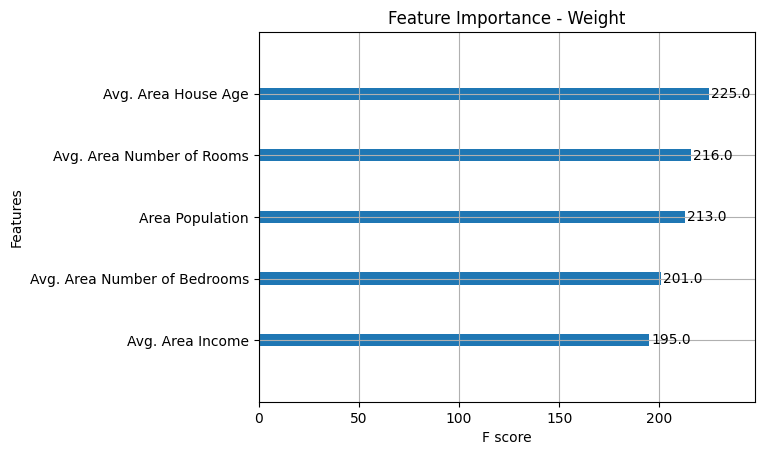

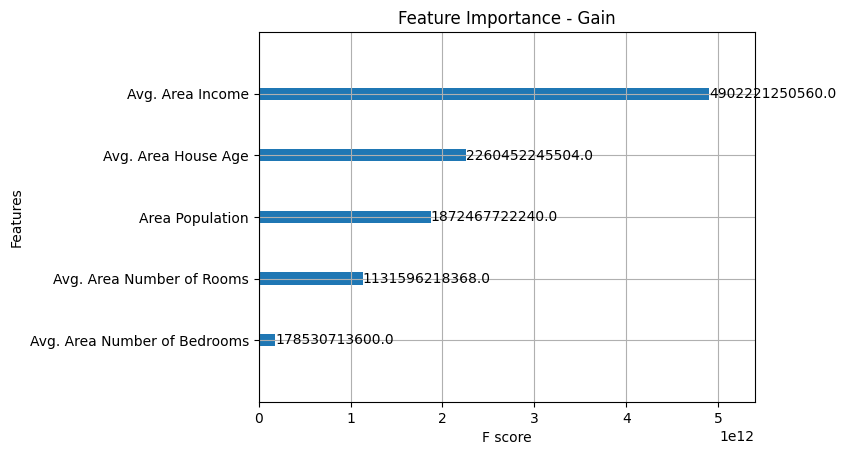

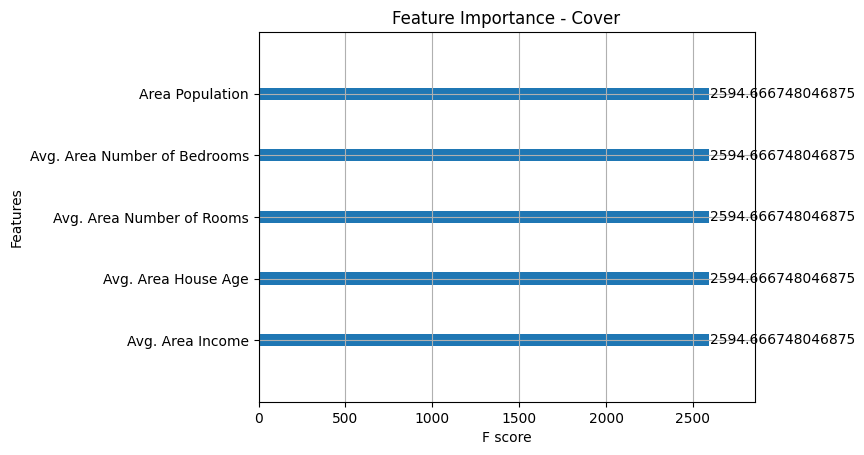

In [16]:
import xgboost as xgb
import matplotlib.pyplot as plt


# Plot the feature importance
xgb.plot_importance(best_xg_reg_filtered, importance_type='weight')
plt.title('Feature Importance - Weight')
plt.show()

# You can also try other types of importance like 'gain' and 'cover'
xgb.plot_importance(best_xg_reg_filtered, importance_type='gain')
plt.title('Feature Importance - Gain')
plt.show()

xgb.plot_importance(best_xg_reg_filtered, importance_type='cover')
plt.title('Feature Importance - Cover')
plt.show()
